# Práctica 3 - Predicción de secuencias
Uxío Merino Currás, Nina López Laudenbach

Comenzamos importando los datos y cargando las librerías necesarias:

In [ ]:
import json
import numpy as np

# Cargamos os datos utilizando a liña de código dada
!wget "https://udcgal.sharepoint.com/:u:/s/GCEDAprendizajeAutomaticoII/EW-oyZUCNkBMvy80CvRjlnABDl5jxrGj1JyXG3C2vr2xAA?e=fcHOnp&download=1" -O data.json

with open('/content/data.json') as file:
    dataset = json.load(file)

--2022-12-17 16:53:51--  https://udcgal.sharepoint.com/:u:/s/GCEDAprendizajeAutomaticoII/EW-oyZUCNkBMvy80CvRjlnABDl5jxrGj1JyXG3C2vr2xAA?e=fcHOnp&download=1
Resolving udcgal.sharepoint.com (udcgal.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to udcgal.sharepoint.com (udcgal.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://udcgal.sharepoint.com/sites/GCEDAprendizajeAutomaticoII/_layouts/15/download.aspx?UniqueId=95c9a86f36024c40bf2f340af4639670 [following]
--2022-12-17 16:53:52--  https://udcgal.sharepoint.com/sites/GCEDAprendizajeAutomaticoII/_layouts/15/download.aspx?UniqueId=95c9a86f36024c40bf2f340af4639670
Reusing existing connection to udcgal.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 9312908 (8.9M) [application/json]
Saving to: ‘data.json’

data.json           100%[===================>]   8.88M  6.33MB/s    in 1.4s    

2022-12-17 16:53:54 (6.33 MB/s)

In [ ]:
import pandas as pd
import datetime

# Transformamos a lista nun DataFrame para continuar co seu tratamento
df = pd.DataFrame(dataset)

## Exploración de los datos
Echamos un vistazo a los datos (solo a los primeros):

In [ ]:
df.head()

,timestamp inicial,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,timestamp final,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros
0,1578038400000,1.11540000,1.12000000,1.11540000,1.11820000,37309.48000000,1578041999999,41775.46427500,31,20419.46000000,22858.82235600
1,1578042000000,1.11820000,1.11820000,1.11510000,1.11510000,2132.61000000,1578045599999,2384.43129200,5,2036.69000000,2277.40107500
2,1578045600000,1.11510000,1.11720000,1.11510000,1.11510000,1950.83000000,1578049199999,2175.39153300,4,10.00000000,11.17200000
3,1578049200000,1.11360000,1.11510000,1.11360000,1.11410000,310.53000000,1578052799999,346.10743800,4,232.00000000,258.65643000
4,1578052800000,1.11260000,1.11330000,1.11260000,1.11330000,394.52000000,1578056399999,439.13042800,3,0.00000000,0.00000000


Para cada fila se guardan 11 variables relacionadas con el precio del dolar en euros: Podemos ver variables relacionadas con la fecha de modificación (para cada hora hay una fila), así como con el precio que tiene el dólar en euros (al principio, al final, el más alto y el más bajo), además podemos ver la cantidad de cambios (compras) que se hicieron y el volumen de los intercambios

Vamos a comprobar también que no hay ningún nulo en ninguna de las columnas con la función df.info(). Como podemos ver, esta indica que hay 24970 no nulos en cada columna que es igual al número de datos, por lo que no tenemos nulos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24970 entries, 0 to 24969
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   timestamp inicial   24970 non-null  int64 
 1   precio inicio       24970 non-null  object
 2   precio mas alto     24970 non-null  object
 3   precio mas bajo     24970 non-null  object
 4   precio fin          24970 non-null  object
 5   volumen             24970 non-null  object
 6   timestamp final     24970 non-null  int64 
 7   volumen en cuotas   24970 non-null  object
 8   numero de compras   24970 non-null  int64 
 9   volumen de dolares  24970 non-null  object
 10  volumen de euros    24970 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.1+ MB


Le echamos un vistazo a las estadísticas de los datos:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
timestamp inicial,24970.0,1.623060e+12,2.598402e+10,1.578038e+12,1.600554e+12,1.623073e+12,1.645566e+12,1.668038e+12
timestamp final,24970.0,1.623063e+12,2.598402e+10,1.578042e+12,1.600557e+12,1.623076e+12,1.645570e+12,1.668042e+12
numero de compras,24970.0,3.249636e+03,4.291602e+03,0.000000e+00,2.980000e+02,2.046000e+03,4.215000e+03,5.391700e+04


Como vemos, muchos datos no aparecen en las estadísticas. Esto es porque no son de tipo numérico, sino que son una cadena de texto (en Pandas esto es 'object'). Esto podemos verlo también en la salida de la función df.info()

Para poder trabajar con estos datos, a continuación vamos a pasarlos todos a tipo numérico. Para esto usamos la siguiente función que va a cambiar todos los tipos de datos, pero no importa mientras todos sean numéricos 

In [ ]:
# Cambiamos el tipo de dato
df = df.astype('float64') 

## Modificación de la fecha
Como vemos, los timestamps están indicados con ms, por lo que para saber a qué fecha se corresponden tendremos que transformarlos a otro tipo de dato. 

Necesitamos esto para poder dividir el conjunto total en entrenamiento y test según las fechas indicadas en el enunciado de la práctica.

Como el timestamp inicial y el final son prácticamente iguales (varían por un segundo) consideramos que a la hora de entrenar, aportan la misma información a la red para ayudar a predecir, por lo que nos quedamos solamente con el timestamp inicial

In [ ]:
# Eliminamos la columna correspondiente al timestamp final
df = df.drop(['timestamp final'], axis=1)

# Guardamos el timestamp en formato datetime
df['timestamp inicial'] = pd.to_datetime(df['timestamp inicial'], unit = 'ms')

df.head()

,timestamp inicial,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros
0,2020-01-03 08:00:00,1.1154,1.1200,1.1154,1.1182,37309.48,41775.464275,31.0,20419.46,22858.822356
1,2020-01-03 09:00:00,1.1182,1.1182,1.1151,1.1151,2132.61,2384.431292,5.0,2036.69,2277.401075
2,2020-01-03 10:00:00,1.1151,1.1172,1.1151,1.1151,1950.83,2175.391533,4.0,10.00,11.172000
3,2020-01-03 11:00:00,1.1136,1.1151,1.1136,1.1141,310.53,346.107438,4.0,232.00,258.656430
4,2020-01-03 12:00:00,1.1126,1.1133,1.1126,1.1133,394.52,439.130428,3.0,0.00,0.000000


A continuación, en vez de guardar el timestamp en s para entrenar, los transformamos para tener en cuenta la periodicidad de los datos, tanto por horas como por días.
Para esto se hace uso del seno y del coseno al igual que en el laboratorio 9.

In [ ]:
# Los volvemos a obtener pero en s en vez de ms para facilitarnos los cálculos y los guardamos en una variable
timestamp_inicial_s = df['timestamp inicial'].map(pd.Timestamp.timestamp)

# Obtenemos el número de s por día y por año
day = 24*60*60
year = day * 365

# Realizamos la conversión
# Para ello primero los pasamos a radianes
Day_inicial_rad = (timestamp_inicial_s/day)*2*np.pi
Ano_inicial_rad = (timestamp_inicial_s/year)*2*np.pi

# Obtenemos las medidas deseadas
df['Dia incial sin'] = np.sin(Day_inicial_rad)
df['Dia inicial cos'] = np.cos(Day_inicial_rad)
df['Año inicial sin'] = np.sin(Ano_inicial_rad)
df['Año inicial cos'] = np.cos(Ano_inicial_rad)

df.head()

,timestamp inicial,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros,Dia incial sin,Dia inicial cos,Año inicial sin,Año inicial cos
0,2020-01-03 08:00:00,1.1154,1.1200,1.1154,1.1182,37309.48,41775.464275,31.0,20419.46,22858.822356,8.660254e-01,-0.500000,0.244241,0.969715
1,2020-01-03 09:00:00,1.1182,1.1182,1.1151,1.1151,2132.61,2384.431292,5.0,2036.69,2277.401075,7.071068e-01,-0.707107,0.244937,0.969539
2,2020-01-03 10:00:00,1.1151,1.1172,1.1151,1.1151,1950.83,2175.391533,4.0,10.00,11.172000,5.000000e-01,-0.866025,0.245632,0.969363
3,2020-01-03 11:00:00,1.1136,1.1151,1.1136,1.1141,310.53,346.107438,4.0,232.00,258.656430,2.588190e-01,-0.965926,0.246327,0.969187
4,2020-01-03 12:00:00,1.1126,1.1133,1.1126,1.1133,394.52,439.130428,3.0,0.00,0.000000,4.199953e-12,-1.000000,0.247022,0.969010


Ahora que ya tenemos todas las variables de tipo numérico y estamos teniendo en cuenta la periodicidad de días y horas, vamos a ver las estadísticas para cada una:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
precio inicio,24970.0,1.126497e+00,6.694923e-02,0.9536,1.080000,1.133000e+00,1.178800e+00,1.309800e+00
precio mas alto,24970.0,1.127797e+00,7.127395e-02,0.9554,1.082000,1.134000e+00,1.179900e+00,4.950000e+00
precio mas bajo,24970.0,1.125329e+00,6.692488e-02,0.9535,1.078000,1.132000e+00,1.177700e+00,1.269500e+00
precio fin,24970.0,1.126459e+00,6.693515e-02,0.9536,1.080000,1.133000e+00,1.178700e+00,1.309800e+00
volumen,24970.0,1.588138e+06,2.435379e+06,0.0000,74407.332500,7.911794e+05,2.069755e+06,4.694843e+07
volumen en cuotas,24970.0,1.831407e+06,2.898230e+06,0.0000,85584.652700,8.722955e+05,2.302447e+06,5.784383e+07
numero de compras,24970.0,3.249636e+03,4.291602e+03,0.0000,298.000000,2.046000e+03,4.215000e+03,5.391700e+04
volumen de dolares,24970.0,7.412968e+05,1.189478e+06,0.0000,31896.420000,3.359175e+05,9.509889e+05,2.354437e+07
volumen de euros,24970.0,8.552054e+05,1.413589e+06,0.0000,36384.047100,3.709915e+05,1.063618e+06,2.905002e+07
Dia incial sin,24970.0,-6.427323e-04,7.070593e-01,-1.0000,-0.707107,-9.541610e-14,7.071068e-01,1.000000e+00


Vemos que no hay ninguno negativo que debería ser positivo. Aunque si se puede ver un dato que no parece normal: el máximo de la variable precio más alto, que no tiene coherencia con los valores que se ven en los cuantiles

A continuación vamos a obtener el índice en el que se encuentra el último dato perteneciente al 2020 que utilizaremos más adelante cuando probemos a eliminar este año

In [ ]:
covid = datetime.datetime(2020, 12, 31, 23, 59)
n_covid = 0
for r in df['timestamp inicial']:
  if r < covid:
    n_covid += 1
print(n_covid)

8710


## Separación del conjunto de datos
Ahora separamos el conjunto total en tres: entrenamiento, validación y test

Para quedarnos con estos conjuntos usamos como separación la fecha indicada en el enunciado de la práctica: de 01/09/2022 00:00:00 en adelante se consideran datos para el conjunto de test, mientras que todos los anteriores son de entrenamiento (70%) y validación (30%).

In [ ]:
# Indicamos la fecha de separación
separacion = datetime.datetime(2022, 8, 31, 23, 59)

# Indicamos la variable por la que queremos guiar la separación y realizamos esta
data = df['timestamp inicial']
df_adestramento = df.loc[data < separacion]
df_test = df.loc[data > separacion]

# Dentro de los datos del entrenamiento separamos en train y validation
n = len(df_adestramento)
df_train = df_adestramento[:round(n * 0.7)]
df_val = df_adestramento[round(n * 0.7):]

# Comporbamos que a suma de ambas particións é igual ao tamaño
assert len(df_test) + len(df_train) + len(df_val) == len(df)

De esta manera, los porcentajes sobre el total de los diferetes conjuntos son:

In [ ]:
print('A porcentaxe do conxunto de train sobre o DF total é: ', 100 * len(df_train) / len(df), '%', '\n'
  'A porcentaxe do conxunto de validación sobre o DF total é: ', 100 * len(df_val) / len(df), '%','\n'
  'A porcentaxe do conxunto de test sobre o DF total é: ', 100 * len(df_test) / len(df), '%')

A porcentaxe do conxunto de train sobre o DF total é:  65.2863436123348 % 
A porcentaxe do conxunto de validación sobre o DF total é:  27.981577893472167 % 
A porcentaxe do conxunto de test sobre o DF total é:  6.732078494193032 %


Para que en el entrenamiento no tenga en cuenta la fecha, sino la periodicidad con horas y días (contemplada al calcular los senos y cosenos), eliminamos la columna de timestamp en formato datetime de ambos conjuntos

In [ ]:
df_train = df_train.drop(['timestamp inicial'], axis=1)
df_val = df_val.drop(['timestamp inicial'], axis=1)
df_test = df_test.drop(['timestamp inicial'], axis=1)

# Mostramos un ejemplo para enseñar que se han eliminado
df_train.head(10)

,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros,Dia incial sin,Dia inicial cos,Año inicial sin,Año inicial cos
0,1.1154,1.1200,1.1154,1.1182,37309.48,41775.464275,31.0,20419.46,22858.822356,8.660254e-01,-0.500000,0.244241,0.969715
1,1.1182,1.1182,1.1151,1.1151,2132.61,2384.431292,5.0,2036.69,2277.401075,7.071068e-01,-0.707107,0.244937,0.969539
2,1.1151,1.1172,1.1151,1.1151,1950.83,2175.391533,4.0,10.00,11.172000,5.000000e-01,-0.866025,0.245632,0.969363
3,1.1136,1.1151,1.1136,1.1141,310.53,346.107438,4.0,232.00,258.656430,2.588190e-01,-0.965926,0.246327,0.969187
4,1.1126,1.1133,1.1126,1.1133,394.52,439.130428,3.0,0.00,0.000000,4.199953e-12,-1.000000,0.247022,0.969010
5,1.1141,1.1174,1.1141,1.1171,2093.90,2335.519448,17.0,1634.99,1824.009728,-2.588190e-01,-0.965926,0.247717,0.968832
6,1.1135,1.1135,1.1135,1.1135,200.34,223.078590,1.0,0.00,0.000000,-5.000000e-01,-0.866025,0.248412,0.968654
7,1.1186,1.1187,1.1155,1.1181,445.36,497.658656,6.0,284.11,317.780285,-7.071068e-01,-0.707107,0.249107,0.968476
8,1.1153,1.1191,1.1142,1.1163,718.84,802.820127,32.0,264.10,295.504234,-8.660254e-01,-0.500000,0.249801,0.968297
9,1.1190,1.1195,1.1162,1.1194,1888.24,2113.661187,9.0,1824.94,2043.005727,-9.659258e-01,-0.258819,0.250496,0.968118


## Predicción sin modificar el dataset
Vamos a probar a obtener la predicción de las seis horas con el dataframe sin modificar para luego al ir eliminando o modificando datos que consideremos erróneos o no relevantes ver si mejora porque influyen negativamente o si realmente no importan.

Lo haremos en principio con una red básica, pensando solamente en la comparación entre dataframe modificados en mayor o menor medida.

Cuando obtengamos un dataframe que nos parezca que lo hará mejor, pasaremos a realizar diferentes pruebas para intentar encontrar una red que lo haga mejor que el resto

## Normalización de los datos
Ahora normalizamos los datos para que estén todos a la misma escala. Importante que hay que usar la media y desviación típica del conjunto de entrenamiento (hay que pensar que es el único conjunto que conoceríamos a priori).
Para normalizar empleamos la siguiente fórmula:

$$ \tilde{x} = \dfrac{x - mean(x)}{std(x)} $$

In [ ]:
# Obtenemos la media y desviación típica
train_mean = df_train.mean()
train_std = df_train.std()

# Normalizamos ambos conjuntos
df_train = (df_train - train_mean) / train_std
df_val = (df_val - train_mean) / train_std
df_test = (df_test - train_mean) / train_std

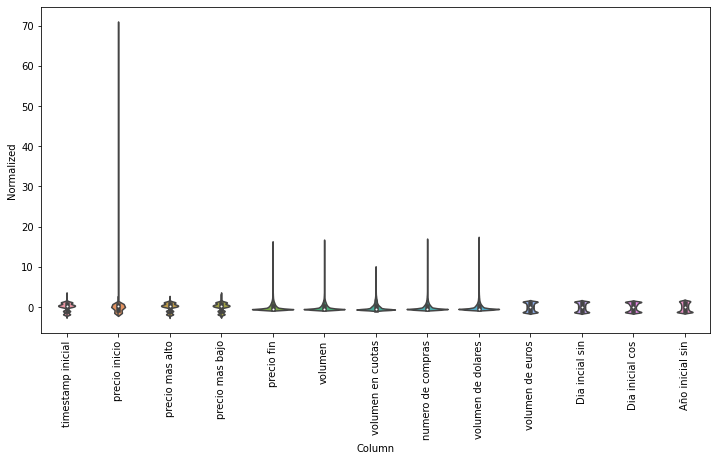

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df_std = df_train.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Pensamos que en precio inicio, el pico viene por un dato que es incorrectamente mucho más alto que el resto (cosa que luego comprobamos)

## Ventana de datos
Cogemos la función del laboratorio 9 empleada para escoger la ventana de datos que se va a emplear, en la que especificamos el número de datos de diferentes tiempos que vamos a meter en el modelo, el número de datos de diferentes tiempo que queremos obtener en la salida y el tiempo a pasar entre la salida y el último dato de la entrada

In [ ]:
def sliding_window(data, labels, input_width, label_width=1, offset=1):
    x = []
    y = []

    for i in range(len(data)-input_width - offset - label_width):
        _x = data[i:i+input_width]
        _y = labels[i+input_width + offset : i + input_width + offset +label_width ]
        x.append(_x)
        y.append(_y)

    x, y = np.array(x),np.array(y)

    if len(x.shape) == 2:
        x = x[:,:,np.newaxis]

    if len(y.shape) == 2:
        y = y[:,:,np.newaxis]

    return x, y

Separamos los conjuntos de datos

In [ ]:
input_width = 70
label_width = 1
offset = 5
target_labels = 'precio fin'

# Llamamos a la función para dividir los conjuntos del dataset
x_train, y_train = sliding_window(df_train,df_train[target_labels], input_width, label_width=label_width, offset=offset)
x_val, y_val = sliding_window(df_val, df_val[target_labels], input_width, label_width=label_width, offset=offset)
x_test, y_test = sliding_window(df_test, df_test[target_labels], input_width, label_width=label_width, offset=offset)

## Selección del modelo
Creamos un modelo que nos permita predecir el precio final del dolar en euros pasadas 6h desde el último dato que le pasamos.

El argumento return_sequences tiene que estar activado en todas las capas excepto en la última para poder concatenar las capas recurrentes. Lo hacemos de esta manera porque así solo devuelve el resultado del paso del tiempo final, y usa los anteriores como 'calentamiento' del estado interno de la red, y como a nosotros solo nos interesa el dato de cuando pasan 6h y no los intermedios, empleamos esta arquitectura

In [ ]:
import tensorflow as tf
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=70, return_sequences=True), 
    tf.keras.layers.LSTM(units=70, return_sequences=False), 
    tf.keras.layers.Dense(units=1), 
])

Usamos la función para entrena que implementa el "early stopping" del laboratorio 9

In [ ]:
#Poñemos unha semente para obter resultados estables
import random
import tensorflow as tf
import os
seed=1234
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


MAX_EPOCHS = 20
batch_size = 32

def entrenar_modelo(model, train_data, train_label, val_data, val_label, epochs, batch_size, patience=5, verbose = 0):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train_data, train_label, epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_label),
                        callbacks=[early_stopping], verbose=verbose)
    return history

In [ ]:
history = entrenar_modelo(lstm_model, x_train, y_train, x_val, y_val, MAX_EPOCHS, batch_size)

In [ ]:
def plot_prediction(feed_data, expected_result, model_result, target_label, input_width, offset=1, index=0):

    f_data_x = np.arange(feed_data.shape[1])
    e_data_x = np.arange(expected_result.shape[1]) + offset + input_width
    plt.plot(f_data_x, feed_data[index])
    plt.plot(e_data_x, expected_result[index], '*r')
    plt.plot(e_data_x, model_result[index], '^g')
    plt.legend(['inputs', 'labels', 'predictions'])
    plt.title(target_label)

51/51 [==============================] - 1s 4ms/step


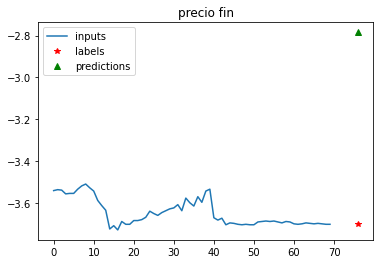

In [ ]:
# Predecimos el resultado del test con el modelo
model_result = lstm_model.predict(x_test)

target_index = df_test.columns.get_loc(target_labels)

# Llama a la función plot_prediction con los parámetros correctos
plot_prediction(x_test[:, :, target_index], y_test, model_result, target_labels, input_width, label_width + offset, index=0)

A continuación, para que lo obtenido se muestre en la escala que es en la realidad, se deshace la normalización, utilizando de nuevo la media y la desviación típica del conjunto de train que oobtuvimos antes.

Como solo estamos prediciendo el precio final, tenemos que indicar que del vector de medias y de la desviación típica, solamente queremos el datos que se corresponde a la variable de precio final

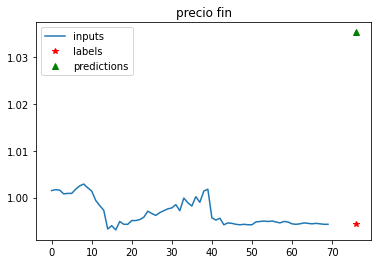

In [ ]:
model_result2 = (model_result*train_std[3]) + train_mean[3]
x_test2 = (x_test*train_std[3]) + train_mean[3]
y_test2 = (y_test*train_std[3]) + train_mean[3]

# Volvemos a representar la gráfica de resultados
plot_prediction(x_test2[:, :, target_index], y_test2, model_result2, target_labels, input_width, label_width + offset, index=0)

Obtenemos el MAE de este modelo:

In [ ]:
mae1 = lstm_model.evaluate(x_test2, y_test2, verbose=0)[1]
print(mae1)

0.03067135252058506


Desnormalizamos los tres conjuntos para seguir trabajando con ellos:

In [ ]:
df_train = df_train * train_std + train_mean
df_val = df_val * train_std + train_mean
df_test = df_test * train_std + train_mean

## Presencia de datos atípicos
Ahora que ya tenemos todo como tipo numérico y además tenemos en cuenta la periodicidad de los datos, veremos si se presentan datos atípicos/anómalos. Como nos interesa que los conjuntos de validación y de test sean lo más parecidos a la realidad vamos a comprobar todo esto tan solo en el conjunto de train. El único cambio que les aplicaremos será la normalización con la nueva media y desviación típica del conjunto de train utilizado de cada vez.

## Comparación de precios
Vamos a añadir una variable que guarde la diferencia entre los precios finales entre una hora y la anterior, y lo mismo para los precios finales. Además, crearemos otra que guarde la diferencia entre el precio final de una hora y el inicial de la siguiente.

De estas variables, nos interesa saber el máximo y el mínimo, ya que si el módulo de estos en algún momento es demasiado grande, significa que hubo un salto de precio demasiado grande, lo cuál es un dato erróneo, y tendríamos que sustituirlo por la media, para que no influyese a la hora de entrenar



In [ ]:
df_train['dif precio ini'] = None
for i in range(1,len(df_train)):
  df_train['dif precio ini'][i] = df_train['precio inicio'][i] - df_train['precio inicio'][i-1]

df_train['dif precio fin'] = None
for i in range(1,len(df_train)):
  df_train['dif precio fin'][i] = df_train['precio fin'][i] - df_train['precio fin'][i-1]

df_train['dif precio ini-fin'] = None
for i in range(1,len(df_train)):
  df_train['dif precio ini-fin'][i] = df_train['precio inicio'][i] - df_train['precio fin'][i-1]

<ipython-input-61-e5c278d6d812>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['dif precio ini'][i] = df_train['precio inicio'][i] - df_train['precio inicio'][i-1]
<ipython-input-61-e5c278d6d812>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['dif precio fin'][i] = df_train['precio fin'][i] - df_train['precio fin'][i-1]
<ipython-input-61-e5c278d6d812>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['dif

In [ ]:
print('En la variable de precio final en train la mayor diferencia es de:', max(max(df_train['dif precio fin'][1:]), abs(min(df_train['dif precio fin'][1:]))))
print('En la variable de precio inicial en train la mayor diferencia es de:', max(max(df_train['dif precio ini'][1:]), abs(min(df_train['dif precio ini'][1:]))))
print('Entre las variables de precio inicial y precio final en train la mayor diferencia es de:', max(max(df_train['dif precio ini-fin'][1:]), abs(min(df_train['dif precio ini-fin'][1:]))))

En la variable de precio final en train la mayor diferencia es de: 0.07620000000000005
En la variable de precio inicial en train la mayor diferencia es de: 0.07610000000000006
Entre las variables de precio inicial y precio final en train la mayor diferencia es de: 0.006600000000000161


Como vemos, en ningún caso hace saltos de precio demasiado altos, por lo que no tenemos ningún dato erróneo que eliminar y por tanto la predicción queda igual. 

Como estas variables las añadimos únicamente para comprobación y no nos interesan para entrenar, las eliminamos

In [ ]:
df_train = df_train.drop(['dif precio fin', 'dif precio ini', 'dif precio ini-fin'], axis=1)

## Datos anómalos
A continuación, representaremos el diagrama de cajas de todas las variables (sin normalizar) para ver en cuáles se presentan datos poco comunes (no erróneos)


In [ ]:
df_train.head()

,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros,Dia incial sin,Dia inicial cos,Año inicial sin,Año inicial cos
0,-0.994575,-0.774086,-0.957218,-0.931217,-0.586343,-0.582969,-0.675476,-0.568781,-0.565517,1.226047,-0.706242,0.318876,1.523885
1,-0.931997,-0.807701,-0.963873,-1.000518,-0.598833,-0.594596,-0.680553,-0.582297,-0.578090,1.001296,-0.999109,0.319831,1.523627
2,-1.001280,-0.826376,-0.963873,-1.000518,-0.598898,-0.594657,-0.680748,-0.583787,-0.579475,0.708393,-1.223833,0.320787,1.523369
3,-1.034804,-0.865592,-0.997145,-1.022873,-0.599480,-0.595197,-0.680748,-0.583624,-0.579323,0.367302,-1.365101,0.321742,1.523111
4,-1.057153,-0.899207,-1.019327,-1.040757,-0.599450,-0.595170,-0.680944,-0.583795,-0.579481,0.001265,-1.413285,0.322696,1.522851


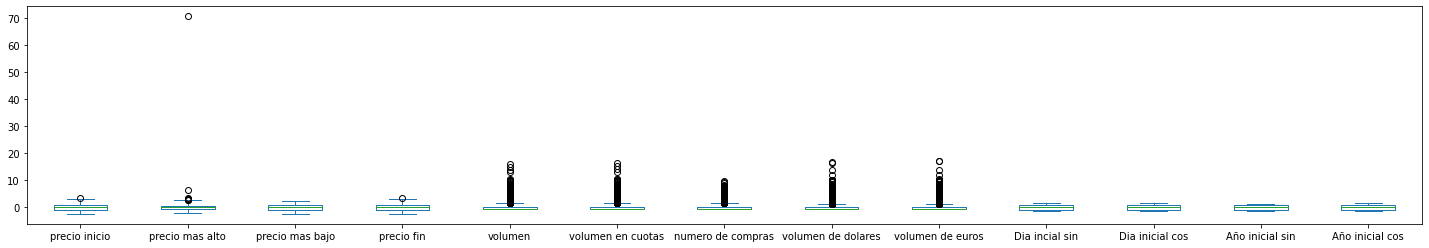

In [ ]:
boxplot = df_train.plot.box(figsize = (25,4))

Como vemos, hay presencia de muchos datos atípicos solo en algunas variables: en volumen, en volumen en cuotas, en volumen de euros y volumen de dólares. También hay alguno en número de compras y en precio más alto.

Los datos atípicos que se representan en las variables de las diferencias de los precios no los tenemos en cuenta

Representamos ahora cada una de estas por separado para que se vean mejor y para ver si los datos atípicos que aparecen arriba son realmente datos probablemente erróneos o que van a influír negativamente, o si simplemente son datos fuera de lo normal pero que podrían ocurrir

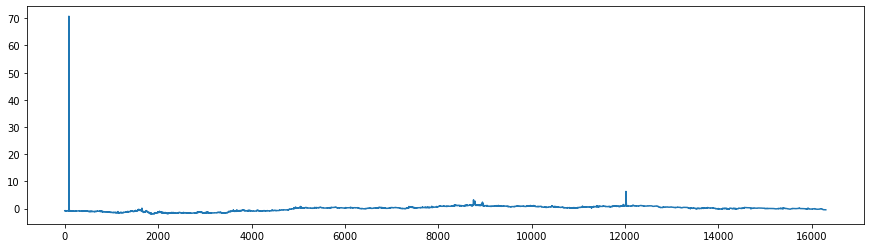

In [ ]:
df_train['precio mas alto'].plot(figsize = (15,4))

Aquí podemos observar como por el principio, hay un dato claramente erróneo ya que es muchas unidades mayor al resto de los datos. Lo vamos a sustituir por la media de esta variable (precio más alto)

In [ ]:
# Obtenemos el índice del dato erróneo y lo sustituímos por la media
indice = df_train['precio mas alto'].idxmax()
media = df_train['precio mas alto'].mean()
df_train['precio mas alto'][indice] = media

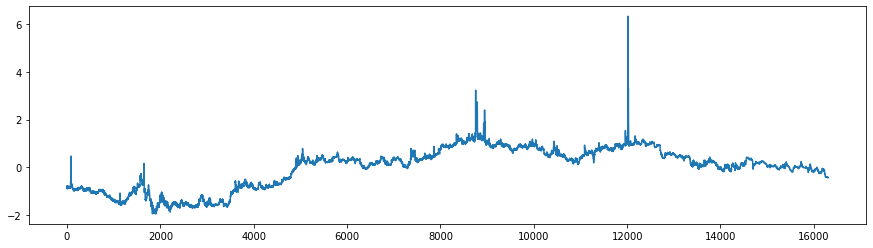

In [ ]:
df_train['precio mas alto'].plot(figsize = (15,4))

Ahora vemos como el dato está eliminado y el resto de datos que más despuntan se pueden deber a datos anómalos pero no erróneos, por lo que de momento no los eliminamos

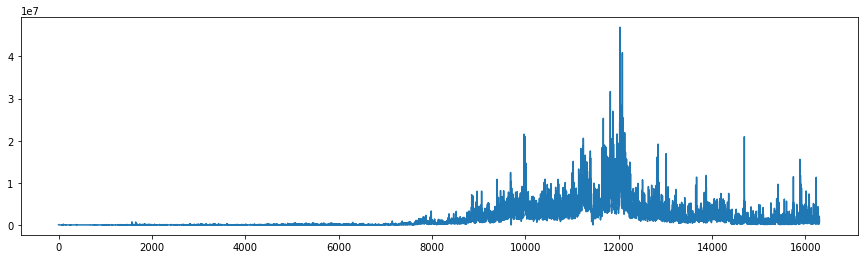

In [ ]:
df_train['volumen'].plot(figsize = (15,4))

Al no entender el significado de esta variable (volumen), no sabemos explicar exactamente la gráfica obtenida.

Sin embargo, creemos que los datos que más despuntan no se deben a que sean datos erróneos, sino simplemente a datos anómalos pero que pueden ser realistas

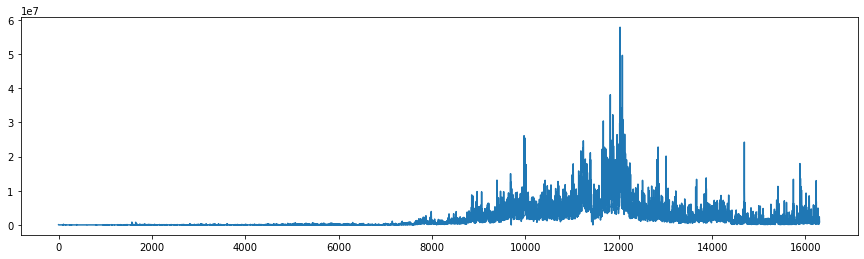

In [ ]:
df_train['volumen en cuotas'].plot(figsize = (15,4))

Para esta variable (volumen en cuotas), sacamos las mismas conclusiones que para la anterior

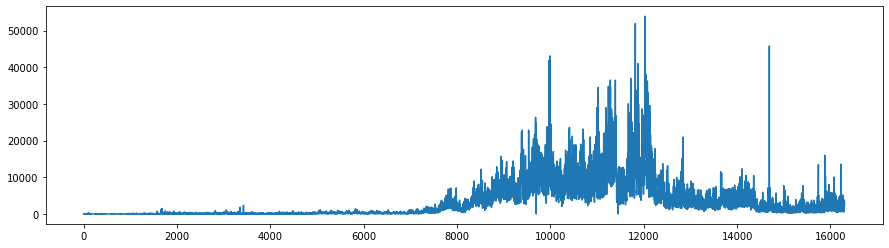

In [ ]:
df_train['numero de compras'].plot(figsize = (15,4))

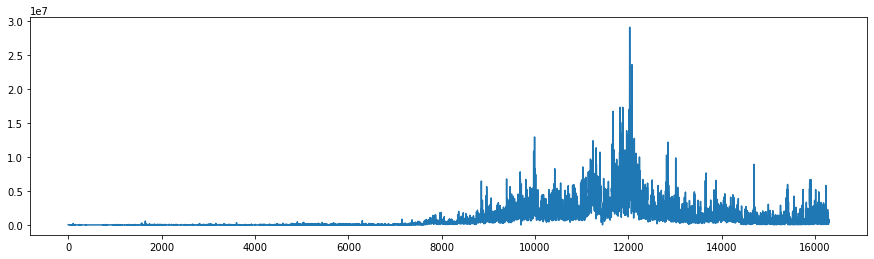

In [ ]:
df_train['volumen de euros'].plot(figsize = (15,4))

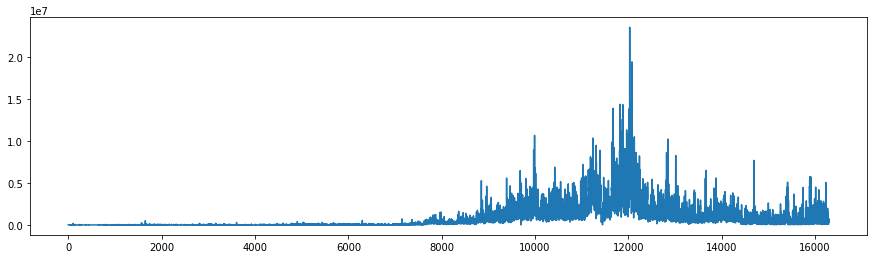

In [ ]:
df_train['volumen de dolares'].plot(figsize = (15,4))

De nuevo, en estas últimas 3 gráficas, consideramos que los datos que más despuntan son solamente datos anómalos pero no erróneos, por lo que de momento no contemplamos eliminarlos

En general en muchas gráficas vemos como el primer tercio de los datos son muy bajos, como si en general hubiera habido pocos cambios en relación con el dólar y el euro. Esto creemos que es así debido a que los primeros años son los correspondientes a la pandemia del Covid. Esto lo trataremos más adelante.

Ahora tras haber modificado el dataset y quitado un dato que parece que afectaba mucho, vamos a volver a ver la gráfica de los datos normalizados para comprobar si el pico en dicha variable se debía a este dato

Primeiro, normalizamos con la media del nuevo DataFrame, sin el dato anómalo

In [ ]:
# Obtenemos las medidas
train_mean = df_train.mean()
train_std = df_train.std()

In [ ]:
# Volvemos a normalizar
train_anomalo = (df_train - train_mean) / train_std
val_anomalo = (df_val - train_mean ) / train_std
test_anomalo = (df_test - train_mean) / train_std

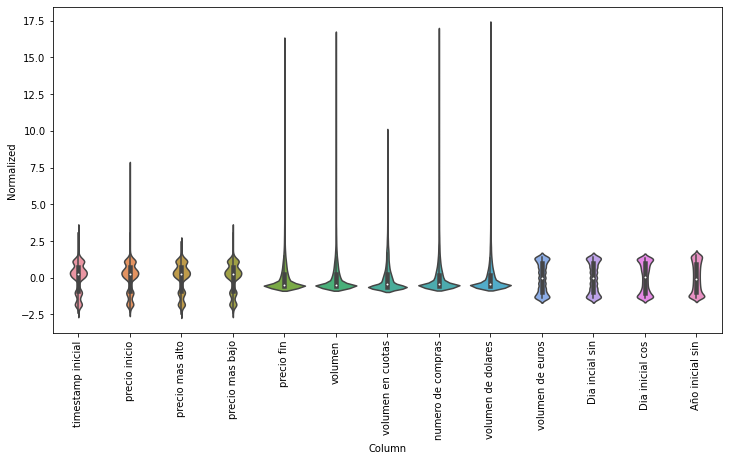

In [ ]:
# Representamos
df_std = train_anomalo.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

Comprobamos que efectivamente los picos se deben a los datos anómalos del dataframe, por lo que los que quedan deben de ser también los que muestra el boxplot

Vamos a entrenar ahora con el dataset modificado, y representamos directamente con la normalización deshecha

In [ ]:
# Tenemos que volver a crear los parámetros x_train e y_train con el nuevo df_train:
x_train_anomalo, y_train_anomalo = sliding_window(train_anomalo,train_anomalo[target_labels], input_width, label_width=label_width, offset=offset)
x_val_anomalo, y_val_anomalo = sliding_window(val_anomalo,val_anomalo[target_labels], input_width, label_width=label_width, offset=offset)
x_test_anomalo, y_test_anomalo = sliding_window(test_anomalo, test_anomalo[target_labels], input_width, label_width=label_width, offset=offset)


history = entrenar_modelo(lstm_model, x_train_anomalo, y_train_anomalo, x_val_anomalo, y_val_anomalo, MAX_EPOCHS, batch_size)

51/51 [==============================] - 1s 15ms/step


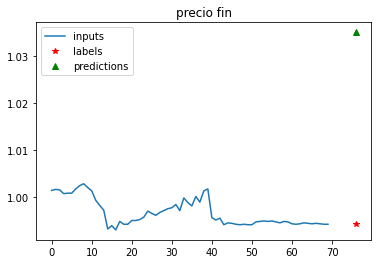

In [ ]:
# Predecimos el resultado del test con el modelo
model_result_anomalo = lstm_model.predict(x_test_anomalo)
target_index_anomalo = test_anomalo.columns.get_loc(target_labels)

# Deshacemos la normalización
model_result2_anomalo = (model_result_anomalo*train_std[3]) + train_mean[3]
x_test2_anomalo = (x_test_anomalo*train_std[3]) + train_mean[3]
y_test2_anomalo = (y_test_anomalo*train_std[3]) + train_mean[3]

# Volvemos a representar la gráfica de resultados
plot_prediction(x_test2_anomalo[:, :, target_index_anomalo], y_test2_anomalo, model_result2_anomalo, target_labels, input_width, label_width + offset, index=0)

In [ ]:
mae2 = lstm_model.evaluate(x_test2_anomalo, y_test2_anomalo, verbose=0)[1]
print(mae2)

0.0042886557057499886


El error de la predicción mejora significativamente, por lo que vamos a trabajar con este nuevo dataframe sin el dato eliminado



In [ ]:
df_train = train_anomalo.copy()
df_val = val_anomalo.copy()
df_test = test_anomalo.copy()
# Atención se copian nomalizados

## Coherencia entre compras y volumen
Ahora vamos a comprobar si hay coherencia entre las columnas de 'numero de compras' y las de 'volumen de dolares' y 'volumen de euros', es decir, si no hay compras no puede haber de volumen de ninguna de las monedas, y viceversa.

Esto lo consideramos así porque tomamos como compras la cantidad de transacciones entre dólares y euros que hubo y volumen de dólares o euros es la cantidad de esa moneda que se movió teniendo en cuenta el precio del momento. Para saber que no es euros que se pasaron a dólares y dólares que se pasaron a euros sino cantidad total representada en ambas monedas, podemos ver algunos ejemplos de filas donde los valores siempre son similares.


In [ ]:
# Deshacemos la normalización
df_train = df_train * train_std + train_mean
df_val = df_val * train_std + train_mean
df_test = df_test * train_std + train_mean

df_train.head(10)

,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros,Dia incial sin,Dia inicial cos,Año inicial sin,Año inicial cos
0,1.209809,1.221425,1.208837,1.209876,1.050764e+11,1.415400e+11,162230.290518,2.777314e+10,3.742062e+10,0.611459,-0.354152,0.189909,0.591769
1,1.209935,1.221329,1.208824,1.209737,6.007759e+09,8.080626e+09,29093.171466,2.770880e+09,3.729032e+09,0.499090,-0.500612,0.190415,0.591650
2,1.209796,1.221275,1.208824,1.209737,5.495812e+09,7.372385e+09,23972.513040,1.439493e+07,1.923706e+07,0.352648,-0.612994,0.190921,0.591530
3,1.209729,1.221163,1.208756,1.209692,8.762344e+08,1.174651e+09,23972.513040,3.163354e+08,4.243666e+08,0.182113,-0.683641,0.191427,0.591409
4,1.209684,1.221067,1.208711,1.209657,1.112776e+09,1.489819e+09,18851.854615,7.940144e+05,9.486054e+05,-0.000895,-0.707737,0.191933,0.591289
5,1.209751,1.221286,1.208779,1.209827,5.898740e+09,7.914909e+09,90541.072567,2.224531e+09,2.986835e+09,-0.183902,-0.683641,0.192439,0.591168
6,1.209724,1.221077,1.208752,1.209666,5.659063e+08,7.578217e+08,8610.537765,7.940144e+05,9.486054e+05,-0.354437,-0.612994,0.192945,0.591046
7,1.209953,1.221356,1.208842,1.209871,1.255956e+09,1.688117e+09,34213.829891,3.872098e+08,5.211518e+08,-0.500879,-0.500612,0.193451,0.590925
8,1.209805,1.221377,1.208783,1.209791,2.026158e+09,2.722024e+09,167350.948944,3.599943e+08,4.846861e+08,-0.613248,-0.354152,0.193956,0.590803
9,1.209971,1.221399,1.208873,1.209929,5.319540e+09,7.163239e+09,49575.805166,2.482880e+09,3.345329e+09,-0.683887,-0.183596,0.194462,0.590680


Como se podía ver también en el inicio de los datos que mostramos al principio, hay filas en las que estos datos no concuerda, en este caso es la fila 4, en la que hay 3 compras y sin embargo no hay volumen ni de dólares ni de euros. Así que controlamos esto:

En el caso de que el número de compras sea 0, lo que haremos será sustituírlo por la media de compras del conjunto de train. Hacemos de manera análoga con las varibles de volumen de dólares y de euros en caso de que ambas sean desconocidas, mientras que si una se conoce, la otra se obtiene aplicando una operación con el precio final conocido para pasar de una moneda a la otra.

El caso en que las 3 sean 0 se considera correcto, ya que puede que en una hora no se realizaran transacciones entre dólares y euros

Lo haremos sobre una copia del dataset en caso de que este tratamiento no ayude a la predicción (como se va a comprobar)

In [ ]:
# Creamos el nuevo dataset que vamos a usar 
new_train = df_train.copy()
new_val = df_val.copy()
new_test = df_test.copy()

# Obtenemos las medidas con las que vamos a sustituir
media_compras = new_train['numero de compras'].mean()
media_dol = new_train['volumen de dolares'].mean()
media_eur = new_train['volumen de euros'].mean()

# Sustituímos según los diferentes casos
for c in range(len(new_train)):
  if new_train['numero de compras'][c] == new_train['volumen de dolares'][c] == new_train['volumen de euros'][c] == 0: ## 0 0 0
    pass # Pasamos porque es un caso realista
  elif new_train['numero de compras'][c] == 0: 
    new_train['numero de compras'][c] = media_compras 
    if new_train['volumen de dolares'][c] == 0 and new_train['volumen de euros'][c] != 0:
      new_train['volumen de dolares'][c] = new_train['volumen de euros'][c] / new_train['precio fin'][c] # transformación de euros a dólares
    elif new_train['volumen de dolares'][c] != 0 and new_train['volumen de euros'][c] == 0: 
      new_train['volumen de euros'][c] = new_train['volumen de dolares'][c] * new_train['precio fin'][c] # transformación de dólares a euros
  elif new_train['numero de compras'][c] != 0: 
    if new_train['volumen de dolares'][c] == 0 and new_train['volumen de euros'][c] == 0: 
      new_train['volumen de dolares'][c] = media_dol
      new_train['volumen de euros'][c] = media_eur
    elif new_train['volumen de dolares'][c] == 0 and new_train['volumen de euros'][c] != 0:
      new_train['volumen de dolares'][c] = new_train['volumen de euros'][c] / new_train['precio fin'][c]
    elif new_train['volumen de dolares'][c] != 0 and new_train['volumen de euros'][c] == 0:
      new_train['volumen de euros'][c] = new_train['volumen de dolares'][c] * new_train['precio fin'][c]

In [ ]:
# Vemos cómo se corrigieron las filas 4 y 6
new_train.head(10)

,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros,Dia incial sin,Dia inicial cos,Año inicial sin,Año inicial cos
0,1.1154,1.1200,1.1154,1.1182,37309.48,41775.464275,31.0,2.041946e+04,2.285882e+04,8.660254e-01,-0.500000,0.244241,0.969715
1,1.1182,1.1182,1.1151,1.1151,2132.61,2384.431292,5.0,2.036690e+03,2.277401e+03,7.071068e-01,-0.707107,0.244937,0.969539
2,1.1151,1.1172,1.1151,1.1151,1950.83,2175.391533,4.0,1.000000e+01,1.117200e+01,5.000000e-01,-0.866025,0.245632,0.969363
3,1.1136,1.1151,1.1136,1.1141,310.53,346.107438,4.0,2.320000e+02,2.586564e+02,2.588190e-01,-0.965926,0.246327,0.969187
4,1.1126,1.1133,1.1126,1.1133,394.52,439.130428,3.0,1.045678e-10,1.164153e-10,4.199953e-12,-1.000000,0.247022,0.969010
5,1.1141,1.1174,1.1141,1.1171,2093.90,2335.519448,17.0,1.634990e+03,1.824010e+03,-2.588190e-01,-0.965926,0.247717,0.968832
6,1.1135,1.1135,1.1135,1.1135,200.34,223.078590,1.0,1.045490e-10,1.164153e-10,-5.000000e-01,-0.866025,0.248412,0.968654
7,1.1186,1.1187,1.1155,1.1181,445.36,497.658656,6.0,2.841100e+02,3.177803e+02,-7.071068e-01,-0.707107,0.249107,0.968476
8,1.1153,1.1191,1.1142,1.1163,718.84,802.820127,32.0,2.641000e+02,2.955042e+02,-8.660254e-01,-0.500000,0.249801,0.968297
9,1.1190,1.1195,1.1162,1.1194,1888.24,2113.661187,9.0,1.824940e+03,2.043006e+03,-9.659258e-01,-0.258819,0.250496,0.968118


Ahora probamos a entrenar a ver si con esto nos mejora la predicción. Para ello tenemos que volver a normalizar

In [ ]:
train_mean = new_train.mean()
train_std = new_train.std()

51/51 [==============================] - 1s 15ms/step


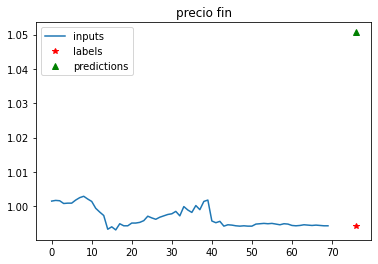

In [ ]:
# Normalizamos
new_train = (new_train - train_mean) / train_std
new_val = (new_val - train_mean) / train_std
new_test = (new_test - train_mean) / train_std

# Tenemos que hacer el enventanado de nuestros nuevos conjuntos
x_new_train, y_new_train = sliding_window(new_train,new_train[target_labels], input_width, label_width=label_width, offset=offset)
x_new_val, y_new_val = sliding_window(new_val,new_val[target_labels], input_width, label_width=label_width, offset=offset)
x_new_test, y_new_test = sliding_window(new_test,new_test[target_labels], input_width, label_width=label_width, offset=offset)

# Entrenamos
history = entrenar_modelo(lstm_model, x_new_train, y_new_train, x_new_val, y_new_val, MAX_EPOCHS, batch_size)

# Predecimos el resultado del test con el modelo
model_result_new = lstm_model.predict(x_new_test)
target_index_new = new_test.columns.get_loc(target_labels)

# Deshacemos la normalización para representar en unidades reales directamente 
model_result_cv = (model_result_new*train_std[3]) + train_mean[3]
x_new_test2 = (x_test*train_std[3]) + train_mean[3]
y_new_test2 = (y_test*train_std[3]) + train_mean[3]

# Volvemos a representar la gráfica de resultados
plot_prediction(x_new_test2[:, :, target_index_new], y_new_test2, model_result_cv, target_labels, input_width, label_width + offset, index=0)

Calculamos el Mean Absolut Error

In [ ]:
mae3 = lstm_model.evaluate(x_new_test2, y_new_test2, verbose=0)[1]
print(mae3)

0.010423416271805763


No hai una mejora en el MAE y como no tenemos claro el significado de estas variables, sino que nos basábamos en suposiciones, vamos a rechazar esta transformación

## Eliminación de 2020
Como vimos más arriba, en 2020 los datos en general son mucho menores en todas las variables, lo que nosotros pensamos que se debe a las circunstancias especiales del Covid, es por esto que para predecir algo del 2022, vamos a probar a tomar datos de la 'normalidad', es decir, eliminando todos los que se corresponden con 2020.
De nuevo, lo hacemos en una copia para no sobreescribir un dataframe ya correcto con una suposición que podría no ser acertada (como se comprueba luego)

In [ ]:
# Vamos a utilizar el índice obtenido al principio para eliminar estas filas del dataframe

# DF xa ndesnormalizados
df_train_20 = df_train.copy()
df_val_20 = df_val.copy()
df_test_20 = df_test.copy()
df_train_20 = df_train_20.drop(range(0,n_covid,1),axis=0)


In [ ]:
# Comprobamos que hemos eliminado las filas
df_train_20

,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros,Dia incial sin,Dia inicial cos,Año inicial sin,Año inicial cos
8710,1.2196,1.2204,1.2160,1.2202,1489724.17,1.814705e+06,4837.0,512221.20,624102.210356,-6.012051e-12,1.000000e+00,0.221922,0.975065
8711,1.2201,1.2265,1.2197,1.2259,1239755.44,1.517177e+06,5570.0,763018.55,933900.490400,2.588190e-01,9.659258e-01,0.222621,0.974905
8712,1.2259,1.2266,1.2244,1.2263,606953.70,7.437827e+05,3482.0,268826.24,329447.789738,5.000000e-01,8.660254e-01,0.223320,0.974745
8713,1.2263,1.2269,1.2260,1.2265,264073.46,3.238729e+05,2575.0,149154.32,182939.140343,7.071068e-01,7.071068e-01,0.224019,0.974585
8714,1.2265,1.2283,1.2218,1.2251,441178.15,5.412586e+05,3273.0,242072.63,297043.777938,8.660254e-01,5.000000e-01,0.224718,0.974424
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16297,1.1380,1.1390,1.1370,1.1380,1326144.00,1.509199e+06,3579.0,506119.10,576174.789000,-8.660254e-01,-5.000000e-01,-0.571420,0.820658
16298,1.1370,1.1380,1.1370,1.1380,1380271.00,1.569979e+06,3646.0,611308.80,695669.414400,-9.659258e-01,-2.588190e-01,-0.570831,0.821067
16299,1.1380,1.1390,1.1370,1.1390,1087798.70,1.237942e+06,3272.0,509875.70,580432.923200,-1.000000e+00,-8.691995e-12,-0.570242,0.821477
16300,1.1390,1.1390,1.1380,1.1380,994822.70,1.132553e+06,2833.0,445035.20,506895.092800,-9.659258e-01,2.588190e-01,-0.569653,0.821885


Ahora vamos a volver a entrenar con el modelo de antes

In [ ]:
# Obtenemos las nuevas medidas de normalización
train_mean = df_train_20.mean()
train_std = df_train_20.std()

In [ ]:
# Volvemos a normalizar
df_train_20 = (df_train_20 - train_mean) / train_std
df_test_20 = (df_test_20 - train_mean) / train_std
df_val_20 = (df_val_20 - train_mean) / train_std

In [ ]:
# Tenemos que volver a crear los parámetros x_train e y_train con el nuevo df_train:
x_train_20, y_train_20 = sliding_window(df_train_20,df_train_20[target_labels], input_width, label_width=label_width, offset=offset)
x_val_20, y_val_20 = sliding_window(df_val_20,df_val_20[target_labels], input_width, label_width=label_width, offset=offset)
x_test_20, y_test_20 = sliding_window(df_test_20,df_test_20[target_labels], input_width, label_width=label_width, offset=offset)

In [ ]:
history = entrenar_modelo(lstm_model, x_train_20, y_train_20, x_val_20, y_val_20, MAX_EPOCHS, batch_size)

51/51 [==============================] - 1s 14ms/step


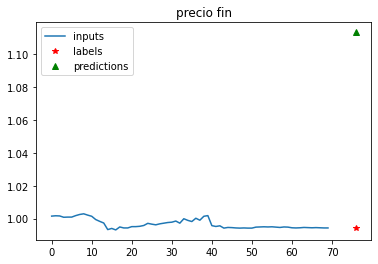

In [ ]:
# Predecimos el resultado del test con el modelo
model_result_20 = lstm_model.predict(x_test_20)
target_index_20 = df_test_20.columns.get_loc(target_labels)

# Deshacemos la normalización
model_result2_20 = (model_result_20*train_std[3]) + train_mean[3]
x_test2_20 = (x_test_20*train_std[3]) + train_mean[3]
y_test2_20 = (y_test_20*train_std[3]) + train_mean[3]

# Volvemos a representar la gráfica de resultados
plot_prediction(x_test2_20[:, :, target_index_20], y_test2_20, model_result2_20, target_labels, input_width, label_width + offset, index=0)

In [ ]:
mae4 = lstm_model.evaluate(x_test2_20, y_test2_20, verbose=0)[1]
print(mae4)

0.028251774609088898


Eliminando el conjunto de datos perteneciente a 2020 funciona mucho peor que con él. Esto se debe a que la parte correspondiente a train tiene la media de la variable que queremos predecir y de otras más alta que la parte que se correspondería con test, por lo que al quitar de train los datos que hacen que baje esa media, ayuda a que el modelo tienda a predecir cosas aún más altas y por tanto aumente el error

## Eliminación del 10% superior
Vamos a coger el 10% de los datos con más valor (los que están a partir del cuantil 0.9) y los vamos a sustituir por la media, ya que son datos anómalos (no incorrectos) y los pasamos a datos más bajos. 

Esto lo hacemos así porque vemos que siempre las predicciones tienen a salir mucho más altas de la realidad, nunca más bajas

De nuevo trabajamos sobre una copia del dataframe

In [ ]:
# Hacemos la copia sobre la que vamos a trabajar (df_train, df_val y df_test están desnormalizados)
train10 = df_train.copy() 
val10 = df_val.copy()
test10 = df_test.copy()

columnas = ['precio mas alto', 'volumen', 'volumen en cuotas', 'numero de compras', 'volumen de euros', 'volumen de dolares']
for columna in columnas:
  num = 0
  q90 = train10[columna].quantile(0.9)
  subs = train10[columna].mean()
  for e in range(len(train10)):
    if train10[columna][e] > q90:
      train10[columna][e] = subs
      num += 1
print(num)

1631


In [ ]:
print(len(train10) * 0.1) # cantidad de datos del 10% de train

1630.2


Con los prints anteriores comprobamos que efectivamente estamos eliminando la cantidad de datos que queremos

Representamos otra vez las gráficas para ver las modificaciones

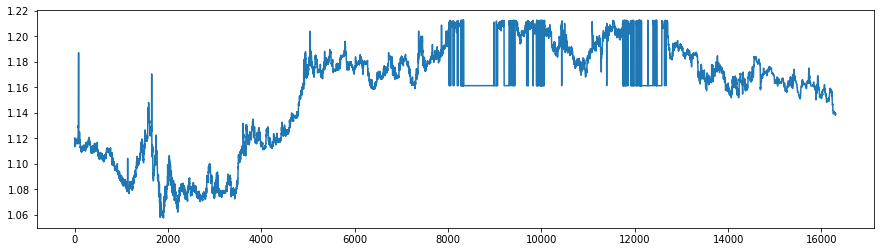

In [ ]:
train10['precio mas alto'].plot(figsize = (15, 4))

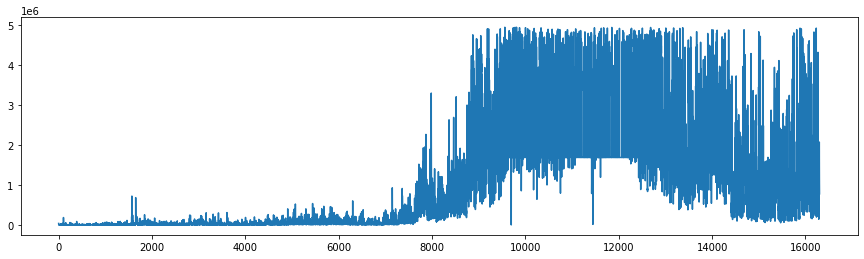

In [ ]:
train10['volumen'].plot(figsize = (15, 4))

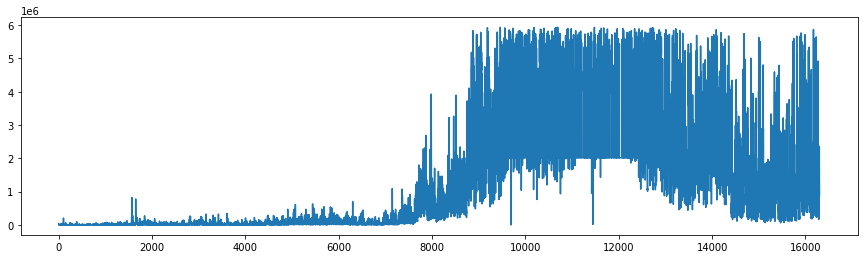

In [ ]:
train10['volumen en cuotas'].plot(figsize = (15, 4))

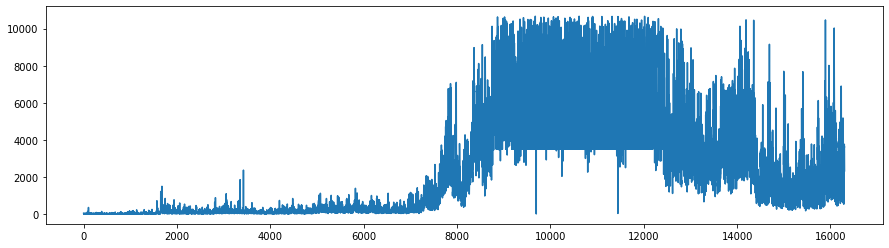

In [ ]:
train10['numero de compras'].plot(figsize = (15, 4))

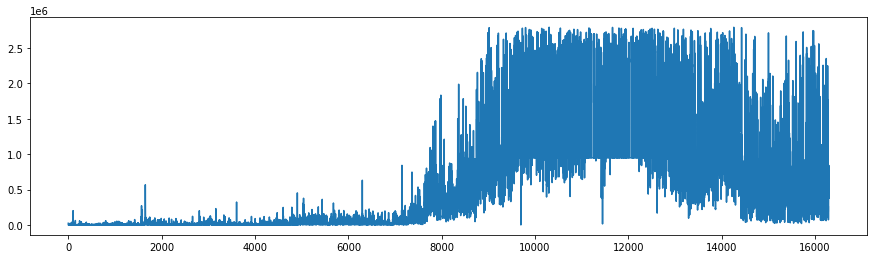

In [ ]:
train10['volumen de euros'].plot(figsize = (15, 4))

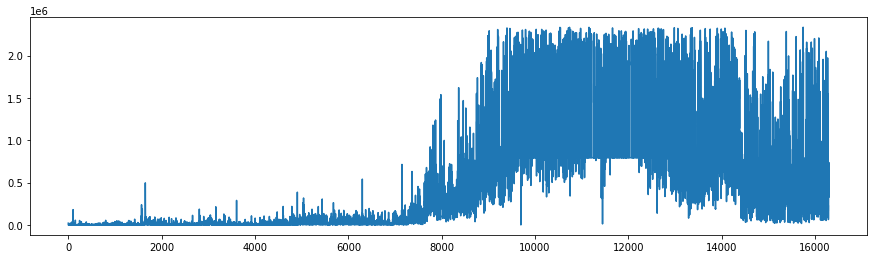

In [ ]:
train10['volumen de dolares'].plot(figsize = (15, 4))

Como se puede ver, ahora las gráficas no tienen picos mucho más diferenciados que el resto, sino que muchos datos pasan a estar a la misma altura

Probamos a entrenar para ver los resultados

In [ ]:
# Obtenemos las nuevas medidas de normlaización
train_mean = train10.mean()
train_std = train10.std()

# Volvemos a normalizar
train10 = (train10 - train_mean) / train_std
val10 = (val10 - train_mean) / train_std
test10 = (test10 - train_mean) / train_std

# Tenemos que volver a aplicar la función sliding_window para todos los conjuntos:
x_train10, y_train10 = sliding_window(train10,train10[target_labels], input_width, label_width=label_width, offset=offset)
x_val10, y_val10 = sliding_window(val10,val10[target_labels], input_width, label_width=label_width, offset=offset)
x_test10, y_test10 = sliding_window(test10,test10[target_labels], input_width, label_width=label_width, offset=offset)

In [ ]:
history = entrenar_modelo(lstm_model, x_train10, y_train10, x_val10, y_val10, MAX_EPOCHS, batch_size)

51/51 [==============================] - 1s 15ms/step


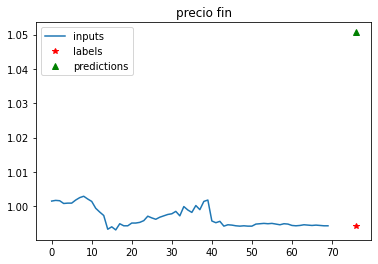

In [ ]:
# Predecimos el resultado del test con el modelo
model_result10 = lstm_model.predict(x_test10)
target_index_10 = test10.columns.get_loc(target_labels)

# Deshacemos la normalización
model_result10_2 = (model_result*train_std[3]) + train_mean[3]
x_test2_10 = (x_test10*train_std[3]) + train_mean[3]
y_test2_10 = (y_test10*train_std[3]) + train_mean[3]

# Volvemos a representar la gráfica de resultados
plot_prediction(x_test2_10[:, :, target_index_10], y_test2_10, model_result10_2, target_labels, input_width, label_width + offset, index=0)

In [ ]:
mae5 = lstm_model.evaluate(x_test2_10, y_test2_10, verbose=0)[1]
print(mae5)

0.004673538263887167


Tampoco nos aporta una mejora tan relevante como eliminar únicamente el dato anómalo del precio, por lo que no aplicamos este cambio al dataframe original. Aunque podemos ver que el error que da es aún así muy bajo (quizá con otro porcentaje que no fuera el 10% daría mejor)

## Modelo de predicción binaria
Ahora vamos a crear una volumna nueva en el dataframe denominada mayor/menor que será una variable booleana que guardará un 1 en caso de que el precio final de ese momento sea mayor al de hace 6h, y un 0 si es menor o igual (porque no interesa saber si sube). Para los seis primeros datos del dataframe va a haber nulos ya que no se tienen datos para comparar de 6h anteriores

Añadimos esa columna a todo el dataframe y separamos, y luego se la añadimos al conjunto de train mejorado que encontramos antes y sustiutimos el de la partición por este

In [ ]:
# Clonamos los dataframes para no usar los mismos
df2 = df.copy()
df_train2 = df_train.copy()
df_val2 = df_val.copy()
df_test2 = df_test.copy()

In [ ]:
# Obtenemos las medidas de normalización
train_mean = df_train2.mean()
train_std = df_train2.std()

# Normalizamos los 3 conjuntos
df_train2 = (df_train2 - train_mean) / train_std
df_val2 = (df_val2 - train_mean) / train_std
df_test2 = (df_test2 - train_mean) / train_std

In [ ]:
# Añadimos la columna al conjunto de train, con las 6 primeras filas nulas
df2['mayor/menor'] = None
for i in range(6,len(df2)):
  if df2['precio fin'][i]-df2['precio fin'][i-6] > 0:
    df2['mayor/menor'][i] = 1 
  else:
    df2['mayor/menor'][i] = 0

<ipython-input-67-6f490dfd5ed1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['mayor/menor'][i] = 0
<ipython-input-67-6f490dfd5ed1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['mayor/menor'][i] = 1


In [ ]:
binario_train = df2['mayor/menor'][:len(df_train2)]
binario_val = df2['mayor/menor'][len(df_train2):len(df_train2)+1+len(df_val2)]
binario_test = df2['mayor/menor'][len(df_train2) + len(df_val2):]

In [ ]:
df_train2['mayor/menor'] = binario_train
df_val2['mayor/menor'] = binario_val
df_test2['mayor/menor'] = binario_test

Si ahora ejecutamos la función .info() veremos que la columna que acabamos de añadir no está en formato numérico, por lo que lo pasamos a este formato en los tres conjuntos

In [ ]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16302 entries, 0 to 16301
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precio inicio       16302 non-null  float64
 1   precio mas alto     16302 non-null  float64
 2   precio mas bajo     16302 non-null  float64
 3   precio fin          16302 non-null  float64
 4   volumen             16302 non-null  float64
 5   volumen en cuotas   16302 non-null  float64
 6   numero de compras   16302 non-null  float64
 7   volumen de dolares  16302 non-null  float64
 8   volumen de euros    16302 non-null  float64
 9   Dia incial sin      16302 non-null  float64
 10  Dia inicial cos     16302 non-null  float64
 11  Año inicial sin     16302 non-null  float64
 12  Año inicial cos     16302 non-null  float64
 13  mayor/menor         16296 non-null  object 
dtypes: float64(13), object(1)
memory usage: 2.4+ MB


In [ ]:
df_train2 = df_train2.astype('float64') 
df_val2 = df_val2.astype('float64') 
df_test2 = df_test2.astype('float64')

Ahora, para que las seis primeras filas de train que en la variable mayor/menor tienen valor null, no nos influyan en el entrenamiento, las eliminamos

In [ ]:
df_train2 = df_train2.drop(range(0,6,1), axis=0)

Comprobamos que se han eliminado

In [ ]:
df_train2.head() 

,precio inicio,precio mas alto,precio mas bajo,precio fin,volumen,volumen en cuotas,numero de compras,volumen de dolares,volumen de euros,Dia incial sin,Dia inicial cos,Año inicial sin,Año inicial cos,mayor/menor
6,-1.037039,-1.070541,-0.999364,-1.036286,-0.599519,-0.595234,-0.681334,-0.583795,-0.579481,-0.705863,-1.223833,0.324605,1.522330,0.0
7,-0.923058,-0.953882,-0.955000,-0.933453,-0.599432,-0.595153,-0.680358,-0.583586,-0.579287,-0.998765,-0.999109,0.325560,1.522069,1.0
8,-0.996810,-0.944908,-0.983836,-0.973692,-0.599335,-0.595062,-0.675280,-0.583600,-0.579301,-1.223517,-0.706242,0.326514,1.521806,1.0
9,-0.914118,-0.935935,-0.939473,-0.904391,-0.598920,-0.594676,-0.679772,-0.582453,-0.578233,-1.364802,-0.365191,0.327468,1.521543,1.0
10,-0.978931,-0.935935,-0.957218,-0.993811,-0.599100,-0.594844,-0.679967,-0.583745,-0.579435,-1.412991,0.000801,0.328422,1.521279,1.0


Ahora nos disponemos a entrenar, y para esto tenemos que cambiar el target_labels, para indicar que lo que queremos predecir ahora es la variable binaria que nos va a decir si la predicción de pasadas 6h va a ser mayor o menor que la última que le demos

In [ ]:
input_width = 70
label_width = 1
offset = 5
target_labels = 'mayor/menor'

# Llamamos a la función para dividir los conjuntos del dataset
x_train2, y_train2 = sliding_window(df_train2,df_train2[target_labels], input_width, label_width=label_width, offset=offset)
x_val2, y_val2 = sliding_window(df_val2, df_val2[target_labels], input_width, label_width=label_width, offset=offset)
x_test2, y_test2 = sliding_window(df_test2, df_test2[target_labels], input_width, label_width=label_width, offset=offset)

Además, no vamos a usar el mismo modelo de antes, por lo que definimos uno nuevo

In [ ]:
lstm_model2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=10, return_sequences=True), 
    tf.keras.layers.LSTM(units=10, return_sequences=False),
    tf.keras.layers.Dense(units=1, activation= 'sigmoid')
])

Modificamos la función de entrenamiento para que en este caso mire el accuracy en vez del mean_absolut_error (ya que ahora trabajamos similar a si fuera clasificación en clases)

In [ ]:
def entrenar_modelo2(model, train_data, train_label, val_data, val_label, epochs, batch_size, patience=5, verbose = 0):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                                      patience=patience,
                                                      mode='max')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.BinaryAccuracy()])

    history = model.fit(train_data, train_label, epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(val_data, val_label),
                        callbacks=[early_stopping], verbose=verbose)
    return history

In [ ]:
MAX_EPOCHS = 20
batch_size = 32
history = entrenar_modelo2(lstm_model2, x_train2, y_train2, x_val2, y_val2, MAX_EPOCHS, batch_size, verbose=1)

Epoch 1/20
507/507 [==============================] - 36s 61ms/step - loss: 0.2455 - binary_accuracy: 0.5499 - val_loss: 0.2507 - val_binary_accuracy: 0.5307
Epoch 2/20
507/507 [==============================] - 29s 57ms/step - loss: 0.2403 - binary_accuracy: 0.5771 - val_loss: 0.2465 - val_binary_accuracy: 0.5487
Epoch 3/20
507/507 [==============================] - 30s 59ms/step - loss: 0.2386 - binary_accuracy: 0.5814 - val_loss: 0.2532 - val_binary_accuracy: 0.5033
Epoch 4/20
507/507 [==============================] - 31s 61ms/step - loss: 0.2376 - binary_accuracy: 0.5816 - val_loss: 0.2470 - val_binary_accuracy: 0.5374
Epoch 5/20
507/507 [==============================] - 29s 57ms/step - loss: 0.2365 - binary_accuracy: 0.5893 - val_loss: 0.2517 - val_binary_accuracy: 0.5034
Epoch 6/20
507/507 [==============================] - 33s 66ms/step - loss: 0.2352 - binary_accuracy: 0.5932 - val_loss: 0.2601 - val_binary_accuracy: 0.4726
Epoch 7/20
507/507 [==============================] 

Predecimos el valor diciendo según la salida de la red, si la predicción se considera mayor o menor a la de 6h antes

In [ ]:
# Predecimos el resultado del test con el modelo
model_resultB = lstm_model2.predict(x_test2, verbose=0)

target_index2 = df_test2.columns.get_loc(target_labels)

if model_resultB[0][0] > 0.5:
  print('O prezo 6 horas despois do último dato proporcionado será maior')
else:
  print('O prezo 6 horas despois do último dato proporcionado será menor')

O prezo 6 horas despois do último dato proporcionado será maior


In [ ]:
ac = lstm_model2.evaluate(x_test2, y_test2, verbose=1)[1]
print(ac)

51/51 [==============================] - 1s 13ms/step - loss: 0.2671 - binary_accuracy: 0.4922
0.49221184849739075


# Conclusións

No primeiro caso, o da predicción do valor final, o mellor DataFrame resultou aquel no que quitamos o valor anómalo na variable precio mas alto, cun MAE de 0.00428. Probamos con varios preprocesados distintos, sempre comparando o seu rendemento co resultado inicial: o mesmo modelo pero traballando co DF en crú, só normalizando e sen ningún outro procesado. A gráfica na que mostramos o resultado non parece achegarse demasiado, pero tratáse dunha escala pequena, polo que seleccionamos o modelo igualmente, fiándonos do MAE da predicción de test xeral, non no individual da gráfica.






No caso binario, tras crear unha nova variable para indicar se é maior ou menor e adestrar con ela, o noso accuracy é extremadamente baixo, máis do normal. Non obstantem probamos con varias arquiteturas (máis capas LSTM e Dense, máis neuronas por capa...) e nunca conseguimos mellorar o modelo. Resulta extraño tamén que, co early stopping, o adestramento sempre se detén no epoch 9, xa que en todos os casos aprende moi pouco, sempre comeza a decrecer o binary accuracy de validacion tras uns poucos epochs. Entendemos que esto está mal, xa que evalúa incluso por debaixo do 0.5 (o cal sería o acc dun modelo aleatorio), pero cambiando a arquitetura non conseguimos mellores resultados

## Baseline
Ahora vamos a definir el modelo que vamos a utilizar de baseline, contra el que luego compararemos nuestro modelo para decir si lo hace mejor o peor.

Para definir este baseline utilizamos el de la librería Scikit-learn: DummyClassifier que obtendrá lo que nosotros le indiquemos en strategy

Para comparar con el modelo que predice el precio final, utilizamos la comparación contra un baseline que predice todo el rato un valor uniforme a partir de la lista valores (cada valor de precio tiene un valor uniforme), mientras que para predecir el binario utilizamos un baseline que devuelve todo el rato una costante, en este caso 1 (es decir, dice que siempre es mayor que el de 6h atrás)

In [ ]:
from sklearn.dummy import DummyClassifier

# Definimos el modelo:
dummy_clf = DummyClassifier(strategy='uniform')
dummy_cte = DummyClassifier(strategy='constant', constant = 1) 

input_width = 70
target_labels = 'precio fin'

Comparación con el modelo de predicción del precio final:

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from tensorflow.python.ops.gen_math_ops import mean_eager_fallback

# Entrenamos este modelo
dummy_clf.fit(x_train[:, 0, :], y_train[:, 0, :])

# Obtenemos el loss:
dummy_predict = dummy_clf.predict(x_test[:, 0, :])

# Obtemos o MAE:
MAE_dummy = mean_absolute_error(y_test[:, 0, :], dummy_predict)

print('MAE do dummy: ', MAE_dummy)
print('MAE do noso modelo: ', mae2)

MAE do dummy:  3.64280266360213
MAE do noso modelo:  0.0042886557057499886


Comparación con el modelo de predicción binaria (mayor o menor):

In [ ]:
from sklearn.metrics import accuracy_score
# Entrenamos este modelo
dummy_cte.fit(x_train2[:, 0, :], y_train2[:, 0, :])

# Obtenemos el loss:
dummyB_predict = dummy_cte.predict(x_test2[:, 0, :])

# Obtemos o MAE:
Acc_dummy = accuracy_score(y_test2[:, 0, :], dummyB_predict)

print('Accuracy do dummy: ', Acc_dummy)
print('Accuracy do noso modelo: ', ac)

Accuracy do dummy:  0.464797507788162
Accuracy do noso modelo:  0.49221184849739075


Observamos como, na comparación frente ao baseline do modelo inicial, o noso modelo resulta claramente favorable, cun valor de MAE moi pequeno. Non obstante,na comparación co modelo binario obtemos un resultado moi similar e moi pobre, pese a ser lixeiramente superior.
Isto concorda coas conclusións obtidas arriba, onde xa recoñecemos que o accuacy binario é menor que un modelo aleatorio, pero que o modelo de predicción do prezo obtén un MAE moi bo.